In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using HDF5
using LaTeXStrings
using Printf
using MCMCChains
using MCMCChainsStorage
using MCMCDiagnosticTools
using StatsBase
using StatsPlots
using Trapz
using Turing


# All requested packages already installed.



InitError: InitError: UndefVarError: `execute_msg` not defined
during initialization of module ArviZ

Here we are fitting 
$$
\frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} m_2 \mathrm{d} V \mathrm{d} t} = \frac{R}{m_1 m_2} g\left( q \right) f\left( m_1 \right) f\left( m_2 \right)
$$
where the "common" mass function
$$
f\left( m \right) = \begin{cases}
\left( \frac{m}{m_b} \right)^{\alpha_1} & m < m_b \\
\left( \frac{m}{m_b} \right)^{\alpha_2} & m \geq m_b 
\end{cases}
$$
and the "pairing" function is a Gaussian in mass ratio, given by 
$$
g\left( q \right) = \exp\left( - \frac{\left( q - \mu_q \right)^2}{2 \sigma_q^2} + \frac{\left( 1 - \mu_q \right)^2}{2 \sigma_q^2}\right)
$$
for 
$$
3 \, M_\odot < m_2 < m_1 < 20 \, M_\odot.
$$
(Note: the definition above implies that $R$ is the volumetric merger rate per log mass squared at $m_1 = m_2 = m_b$.)

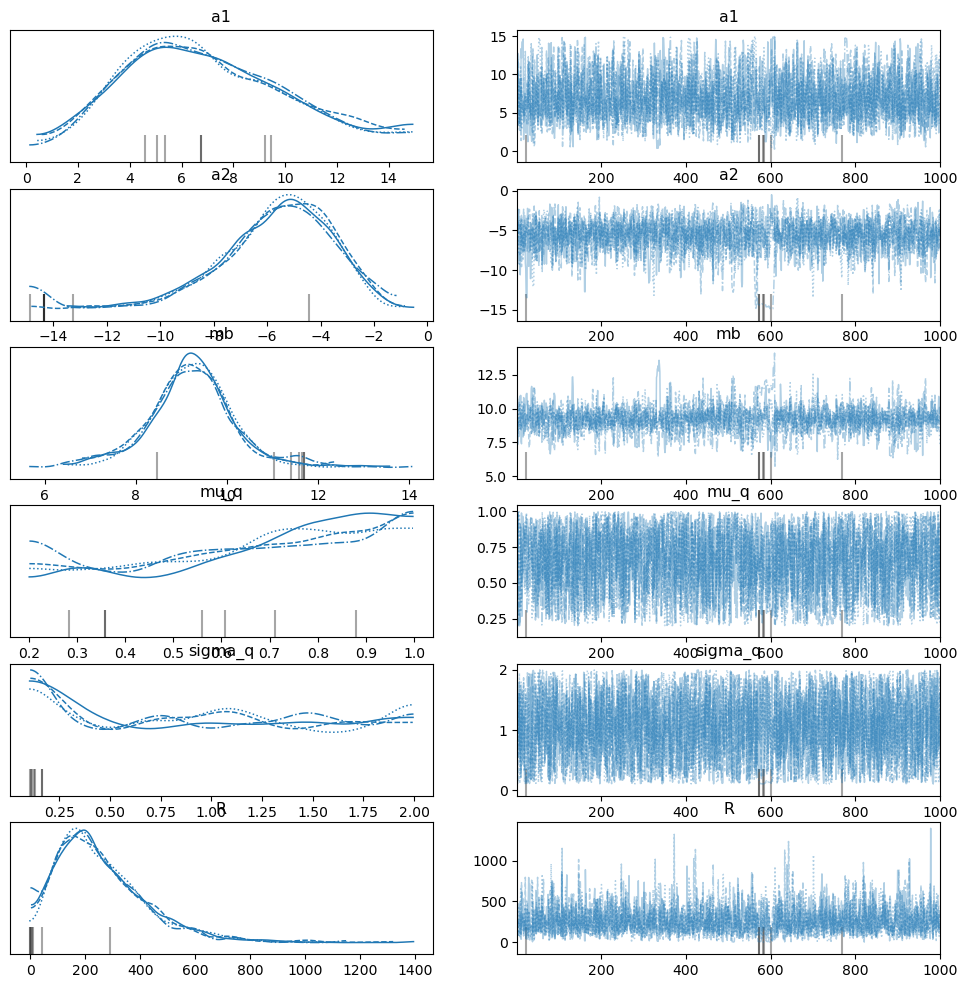

6×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ a1          6.993    3.105    1.459   12.838      0.066    0.05     218 ⋯
   2 │ a2         -5.643    2.176   -9.386   -1.919      0.094    0.088    109
   3 │ mb          9.224    0.93     7.273   10.999      0.029    0.022    119
   4 │ mu_q        0.649    0.232    0.258    0.999      0.005    0.004    214
   5 │ sigma_q     1.008    0.571    0.1      1.893      0.012    0.008    179 ⋯
   6 │ R         259.0    167.591    0.001  554.745      3.168    2.241    124
                                                               3 columns omitted

In [3]:
trace = from_netcdf(joinpath(@__DIR__, "..", "chains", "chain.nc"))
var_names = ["a1", "a2", "mb", "mu_q", "sigma_q", "R"]
plot_trace(trace, var_names=var_names)
summarystats(trace, var_names=var_names)

In [4]:
post = trace.posterior
dNdm1dm2 = map(post.a1, post.a2, post.mb, post.mu_q, post.sigma_q, post.R) do a1, a2, mb, mu_q, sigma_q, R
    ldN = make_log_dN(a1, a2, mb, mu_q, sigma_q)
    (m1, m2) -> R*exp(ldN(m1,m2))
end
dNdm1 = map(post.a1, post.a2, post.mb, post.mu_q, post.sigma_q, post.R) do a1, a2, mb, mu_q, sigma_q, R
    dN = make_dNdm1(a1, a2, mb, mu_q, sigma_q)
    m1 -> R*dN(m1)
end
dNdm2 = map(post.a1, post.a2, post.mb, post.mu_q, post.sigma_q, post.R) do a1, a2, mb, mu_q, sigma_q, R
    dN = make_dNdm2(a1, a2, mb, mu_q, sigma_q)
    m2 -> R*dN(m2)
end
dNdq = map(post.a1, post.a2, post.mb, post.mu_q, post.sigma_q, post.R) do a1, a2, mb, mu_q, sigma_q, R
    dN = make_dNdq(a1, a2, mb, mu_q, sigma_q)
    q -> R*dN(q)
end
dNdm_pl = map(post.a1, post.a2, post.mb, post.R) do a1, a2, mb, R
    dN = make_dNdm(a1, a2, mb)
    m -> R*dN(m)
end
pprob = map(post.mu_q, post.sigma_q) do mu_q, sigma_q
    pf = make_pairing_prob(mu_q, sigma_q)
    q -> pf(q)
end;

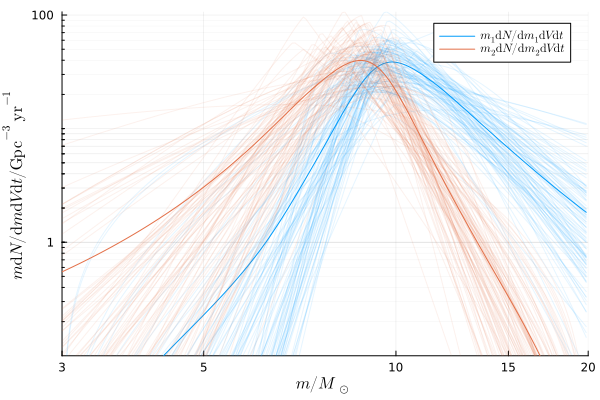

In [5]:
ms = exp.(log(mlow):0.01:log(mhigh))
dN1_mean = zeros(length(ms))
dN2_mean = zeros(length(ms))

p = plot(xlabel=L"m / M_\odot", ylabel=L"m \mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", minorgrid=true, yscale=:log10, ylims=(0.1, Inf), xscale=:log10, xlims=(3, 20), xticks=[3, 5, 10, 15, 20], formatter=(x->@sprintf("%g", x)))

for dN in dNdm1
    dN1_mean = dN1_mean .+ dN.(ms)
end
dN1_mean = dN1_mean ./ length(dNdm1)
p = plot!(ms, ms.*dN1_mean, label=L"m_1 \mathrm{d}N/\mathrm{d}m_1\mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, ms.*sample(dNdm1).(ms), color=1, alpha=0.1, label=nothing)
end

for dN in dNdm2
    dN2_mean = dN2_mean .+ dN.(ms)
end
dN2_mean = dN2_mean ./ length(dNdm1)
p = plot!(ms, ms.*dN2_mean, color=2, label=L"m_2 \mathrm{d}N/\mathrm{d}m_2 \mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, ms.*sample(dNdm2).(ms), color=2, alpha=0.1, label=nothing)
end

p

How about the "common" part of the mass function?

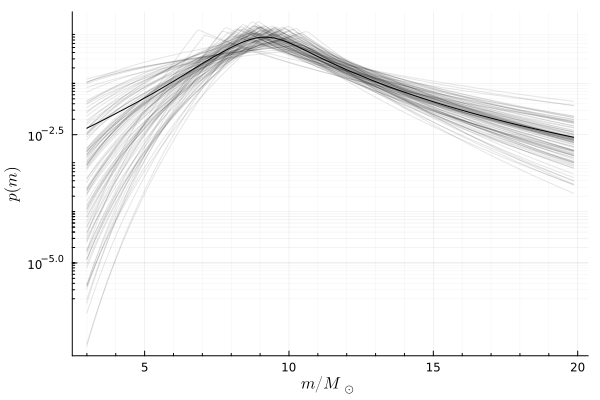

In [6]:
p = plot(xlabel=L"m/M_\odot", ylabel=L"p(m)", yscale=:log10, minorgrid=true)
dN_mean = zeros(length(ms))

for dN in dNdm_pl
    dN_mean = dN_mean .+ dN.(ms)
end
dN_mean = dN_mean ./ length(dNdm_pl)
dN_mean = dN_mean ./ trapz(ms, dN_mean)

p = plot!(ms, dN_mean, color=:black, label=nothing)
for _ in 1:100
    pp = sample(dNdm_pl).(ms)
    pp = pp ./ trapz(ms, pp)
    p = plot!(ms, pp, color=:black, alpha=0.1, label=nothing)
end
p

It is interesting to ask about properties of the *peak* itself---here are its first and second moments:

In [7]:
mus = Float64[]
sigmas = Float64[]
for dN in dNdm_pl
    pm = dN.(ms)
    pm = pm / trapz(ms, pm)

    mu = trapz(ms, ms .* pm)
    push!(mus, mu)

    v = trapz(ms, (ms .- mu).^2 .* pm)
    push!(sigmas, sqrt(v))
end

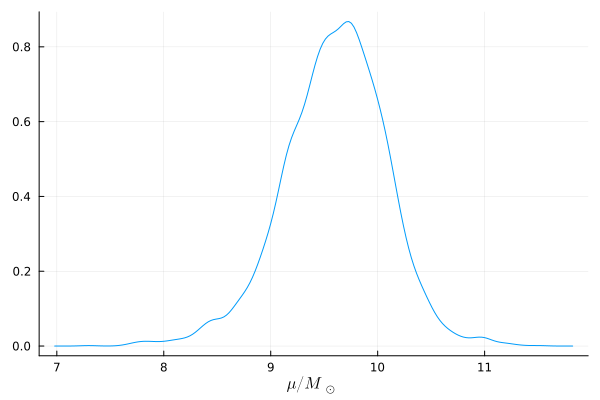

In [8]:
density(mus, label=nothing, xlabel=L"\mu / M_\odot")

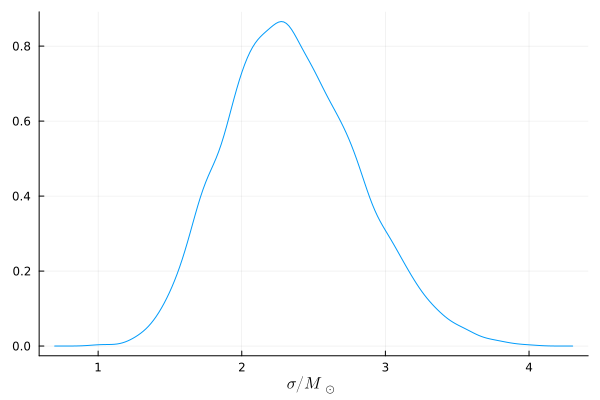

In [9]:
density(sigmas, label=nothing, xlabel=L"\sigma / M_\odot")

It looks like the peak has about 25% fractional width.

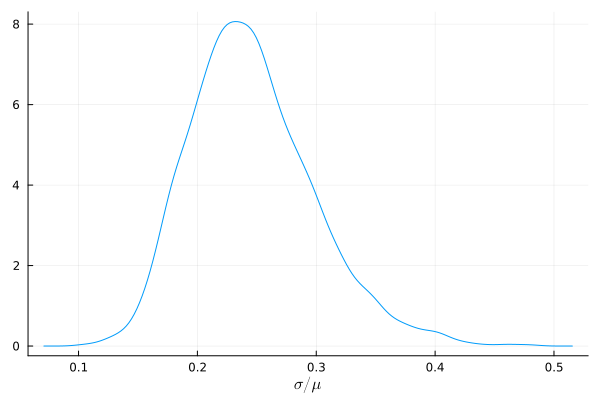

In [10]:
density(sigmas ./ mus, label=nothing, xlabel=L"\sigma / \mu")

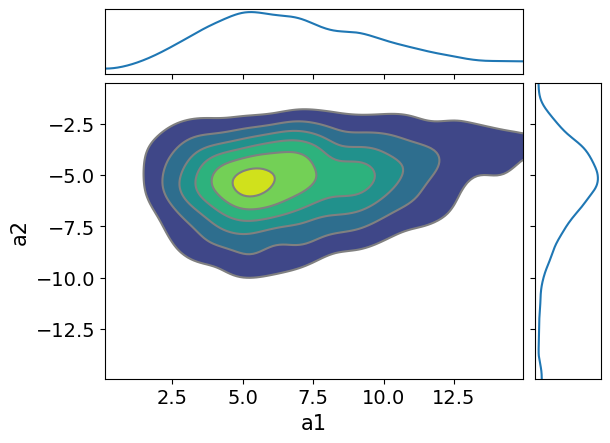

2×2 Matrix{PyCall.PyObject}:
 PyObject <Axes: >                          PyObject None
 PyObject <Axes: xlabel='a1', ylabel='a2'>  PyObject <Axes: >

In [11]:
plot_pair(trace, var_names=["a1", "a2"], marginals=true, kind="kde")

Let's look at $\mathrm{d} N/\mathrm{d} q$:

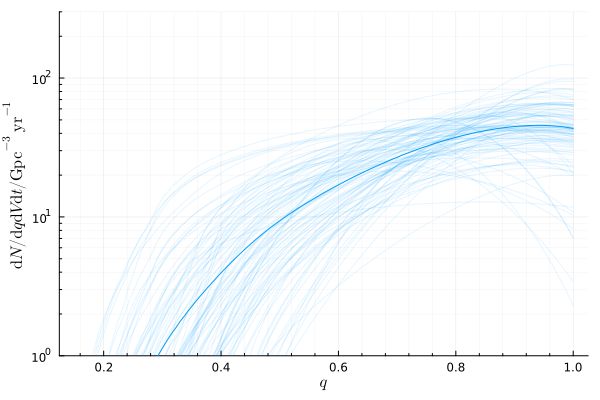

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [12]:
qs = collect(range(mlow/mhigh, stop=1, length=128))
dNdq_mean = zeros(length(qs))

for dN in dNdq
    dNdq_mean .= dNdq_mean .+ dN.(qs)
end
dNdq_mean .= dNdq_mean ./ length(dNdq)
p = plot(qs, dNdq_mean, color=1, yscale=:log10, ylims=(1e0, 3e2), legend=nothing, minorgrid=true, xlabel=L"q", ylabel=L"\mathrm{d}N/\mathrm{d}q\mathrm{d}V\mathrm{d}t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}")

for _ in 1:100
    p = plot!(qs, sample(dNdq).(qs), color=1, alpha=0.1)
end

p

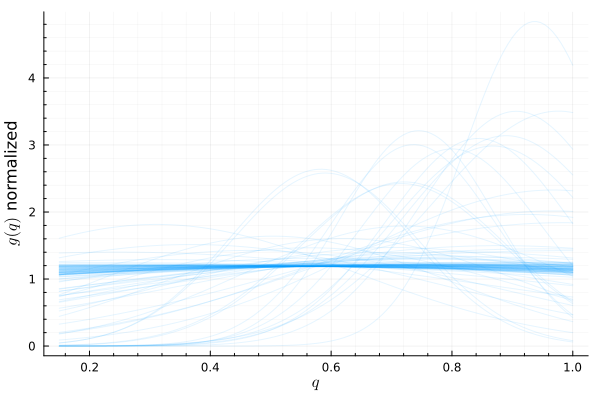

In [13]:
pp = plot(xlabel=L"q", ylabel=L"$g(q)$ normalized", legend=nothing, minorgrid=true)
for _ in 1:100
    p = sample(pprob)
    pb = p.(qs)
    pb /= trapz(qs, pb)
    pp = plot!(qs, pb, color=1, alpha=0.1, label=nothing)
end
pp

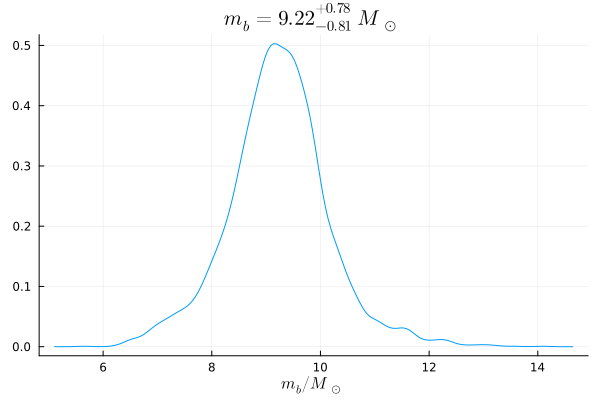

In [14]:
x = vec(trace.posterior.mb)
l = quantile(x, 0.16)
m = quantile(x, 0.5)
h = quantile(x, 0.84)

density(x, xlabel=L"m_b / M_\odot", label=nothing)
p = title!(@sprintf("\$m_b = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l))

p

In [15]:
function m1pct(ms, f)
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 1 method)

In [16]:
m1pct_m1 = map(dNdm1) do dN
    m1pct(ms, dN)
end
m1pct_m2 = map(dNdm2) do dN
    m1pct(ms, dN)
end
m1pct_pl = map(dNdm_pl) do dN
    m1pct(ms, dN)
end;

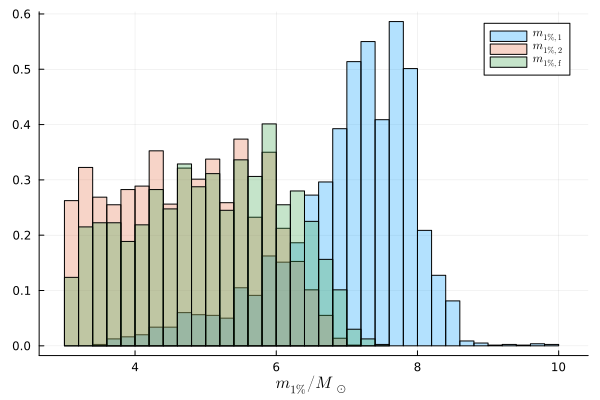

In [17]:
histogram(vec(m1pct_m1), label=L"m_{1\%,1}", xlabel=L"m_{1\%} / M_\odot", fillalpha=0.3, norm=:pdf)
histogram!(vec(m1pct_m2), label=L"m_{1\%,2}", fillalpha=0.3, norm=:pdf)
histogram!(vec(m1pct_pl), label=L"m_{1\%,\mathrm{f}}", fillalpha=0.3, norm=:pdf)

Let's do some model checking.  First, we plot the population-informed posteriors for $m_1$ and $m_2$:

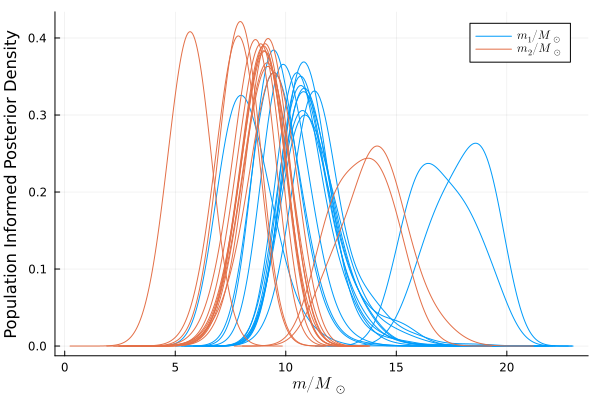

In [18]:
p = plot(xlabel=L"m / M_\odot", ylabel="Population Informed Posterior Density")
m1label = L"m_1 / M_\odot"
for n in DimensionalData.index(trace.posterior, :gwnames)
    p = density!(vec(trace.posterior.m1s_popwt[gwnames=At(n)]), color=1, label=m1label, bandwidth=0.75)
    m1label = nothing
end
m2label = L"m_2 / M_\odot"
for n in DimensionalData.index(trace.posterior, :gwnames)
    p = density!(vec(trace.posterior.m2s_popwt[gwnames=At(n)]), color=2, label=m2label, bandwidth=0.75)
    m2label = nothing
end
p

I bet our inference about the minimum BH mass is being driven by that one outlier.  Let's look:

In [19]:
nmin = ""
mmin = Inf
for n in DimensionalData.index(trace.posterior, :gwnames)
    mm = minimum(trace.posterior.m2s_popwt[gwnames=At(n)])

    if mm < mmin
        mmin = mm
        nmin = n
    end
    println("minimum(m2, $(n)): $(mm)")
end

println("Overall minimum is $(nmin)")

minimum(m2, GW190707_093326): 6.447149637066
minimum(m2, GW190708_232457): 10.676955710112418
minimum(m2, GW190720_000836): 5.835974895897672
minimum(m2, GW190728_064510): 5.890454978348947
minimum(m2, GW190924_021846): 3.2416786166579667
minimum(m2, GW190930_133541): 5.434838345873358
minimum(m2, GW191103_012549): 5.214392380367394
minimum(m2, GW191105_143521): 5.641627114842894
minimum(m2, GW191126_115259): 5.934334459250401
minimum(m2, GW191129_134029): 4.90182219880026
minimum(m2, GW191204_171526): 6.124538344275256
minimum(m2, GW191216_213338): 5.827383069546859
minimum(m2, GW200202_154313): 5.475846486438653
minimum(m2, GW200225_060421): 11.043419979258585
minimum(m2, GW200316_215756): 5.8039736743853485
Overall minimum is GW190924_021846


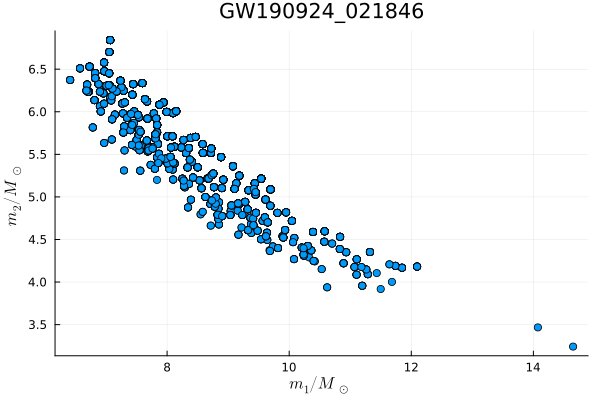

In [20]:
post = trace.posterior
scatter(vec(post.m1s_popwt[gwnames=At(nmin)]), vec(post.m2s_popwt[gwnames=At(nmin)]), label=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", title=nmin)